In [1]:
import torch
from torch import nn
import torchvision.datasets as datasets 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Loading the dataset and viewing samples

In [2]:
training_data = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
testing_data = datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

Displaying a few sample images

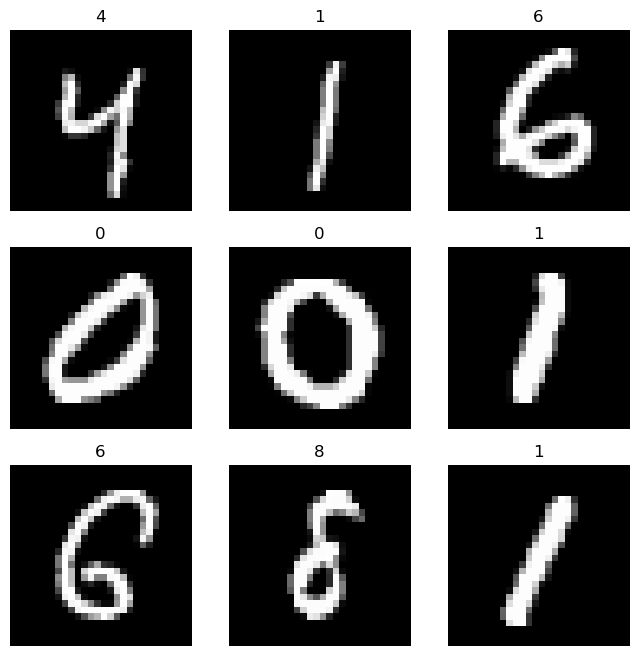

In [3]:
figure = plt.figure(figsize = (8,8))
rows, cols = 3, 3

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

## Classes and functions

In [6]:
device = (    
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )

In [41]:
class Trainer():
  def __init__(self):
    self.training_losses = []
    self.training_losses_avg = []
    self.testing_losses = []

  def train(self, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        self.training_losses.append(loss)

  def test(self, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    self.testing_losses.append(test_loss)
    self.training_losses_avg.append(correct)

  def plot_training_losses(self):
    epochs = range(1, len(self.training_losses_avg) + 1)
    plt.plot(epochs, self.training_losses_avg, 'bo', label='Training loss')
    plt.plot(epochs, self.testing_losses, 'b', label='Testing loss')
    plt.title('Training and testing loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    pixel_size = 784
    # transforms each 2D (28x28) image into an array of 784 pixel values
    self.flatten = nn.Flatten()
    # nn.Sequential is an ordered container of modules
    self.linear_stack = nn.Sequential(
      nn.Linear(pixel_size, 128, bias=False),
      nn.Linear(128, 32, bias=False),
      nn.Linear(32, 10, bias=False)
    )
  
  def forward(self, x):
    x = self.flatten(x) # flatten inputs
    prediction = self.linear_stack(x) # make prediction
    return prediction

In [21]:
class NonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    pixel_size = 784
    # transforms each 2D (28x28) image into an array of 784 pixel values
    self.flatten = nn.Flatten()
    # nn.Sequential is an ordered container of modules
    self.linear_stack = nn.Sequential(
      nn.Linear(pixel_size, 300, bias=True),
      nn.LeakyReLU(),
      nn.Linear(300, 300, bias=True),
      nn.LeakyReLU(),
      nn.Linear(300, 300, bias=True),
      nn.LeakyReLU(),
      nn.Linear(300, 10, bias=True),
    )
  
  def forward(self, x):
    x = self.flatten(x) # flatten inputs
    prediction = self.linear_stack(x) # make prediction
    return prediction
  
non_linear_model = NonLinearModel().to(device)

## Making predictions before training

Getting a random sample

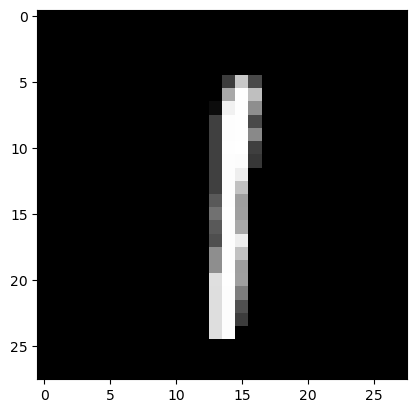

In [9]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")

Linear model prediction

In [10]:
model = LinearModel().to(device)

output = model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([0])
Actual:  1


In [11]:
output = non_linear_model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([4])
Actual:  1


In [12]:
linear_accuracy = 0
non_linear_accuracy = 0

for i in range(0, 50):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  output = model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    linear_accuracy += 1

  output = non_linear_model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    non_linear_accuracy += 1

print("Linear Accuracy: ", linear_accuracy)
print("Non Linear Accuracy: ", non_linear_accuracy)

Linear Accuracy:  1
Non Linear Accuracy:  7


## Training loop (linear model)

In [13]:
# Linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, model, loss_fn, optimizer)
  test(testing_loader, model, loss_fn)
print("Done!")

# torch.save(model.state_dict(), "model.pth")
# print("Saved PyTorch Model State to model.pth")

Epoch 1
-------------------------------
loss: 2.312801  [    0/60000]
loss: 2.295668  [ 6400/60000]
loss: 2.256284  [12800/60000]
loss: 2.225407  [19200/60000]
loss: 2.197168  [25600/60000]
loss: 2.179203  [32000/60000]
loss: 2.139970  [38400/60000]
loss: 2.106477  [44800/60000]
loss: 2.082035  [51200/60000]
loss: 2.022376  [57600/60000]
Test Error: 
 Accuracy: 56.1%, Avg loss: 2.012150 

Epoch 2
-------------------------------
loss: 2.008440  [    0/60000]
loss: 1.916349  [ 6400/60000]
loss: 1.974174  [12800/60000]
loss: 1.810220  [19200/60000]
loss: 1.780149  [25600/60000]
loss: 1.764653  [32000/60000]
loss: 1.727628  [38400/60000]
loss: 1.551589  [44800/60000]
loss: 1.584312  [51200/60000]
loss: 1.514287  [57600/60000]
Test Error: 
 Accuracy: 68.5%, Avg loss: 1.484116 

Epoch 3
-------------------------------
loss: 1.549332  [    0/60000]
loss: 1.415380  [ 6400/60000]
loss: 1.406141  [12800/60000]
loss: 1.237182  [19200/60000]
loss: 1.260945  [25600/60000]
loss: 1.181237  [32000/600

## Training loop (non-linear model)

In [ ]:
# non-linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, non_linear_model, loss_fn, optimizer)
  test_loss = test(testing_loader, non_linear_model, loss_fn)
print("Done!")

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer()

epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  trainer.train(training_loader, non_linear_model, loss_fn, optimizer)
  trainer.test(testing_loader, non_linear_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302936  [    0/60000]
loss: 2.303965  [ 6400/60000]
loss: 2.296484  [12800/60000]


KeyboardInterrupt: 

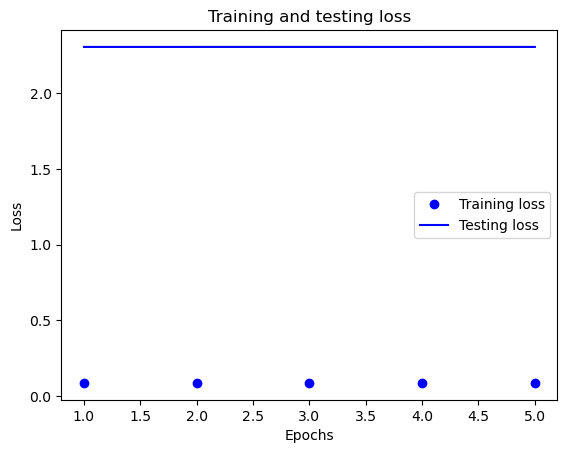

In [43]:
trainer.plot_training_losses()